In [17]:
import datetime
from calendar_ipynb.google_oauth import verify_credentials
from calendar_ipynb.events import process_events_and_classify, fetch_events_parallel, get_primary_timezone, pretty_print_timedelta
from calendar_ipynb.ipywidgets.calendar_selection import (
    select_calendars,
    get_selected_calendars,
)
from calendar_ipynb.ipywidgets.date_range_selection import get_selected_date_range

%matplotlib widget
%load_ext autoreload
# Automatically reload all modules
%autoreload 2

EMAIL_IDS = ["fahimalizain@gmail.com", "fahim.zain@kwalee.com"]

for email in EMAIL_IDS:
    verify_credentials(email)

INFO:calendar_ipynb.google_oauth:Verifying credentials for fahimalizain@gmail.com
INFO:calendar_ipynb.google_oauth:✅ Credentials found for fahimalizain@gmail.com
INFO:calendar_ipynb.google_oauth:Verifying credentials for fahim.zain@kwalee.com
INFO:calendar_ipynb.google_oauth:✅ Credentials found for fahim.zain@kwalee.com


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
select_calendars(EMAIL_IDS)
selected_calendars = get_selected_calendars()
if not selected_calendars:
    raise ValueError("No calendars selected")

primary_timezone = get_primary_timezone(selected_calendars=selected_calendars)

INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0


INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0


INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0


In [19]:
from_datetime, to_datetime = get_selected_date_range(timezone=primary_timezone)
if not from_datetime or not to_datetime:
    raise ValueError("Please provide from_date and to_date")

print("Date Range:", from_datetime, " TO ", to_datetime, 'in Timezone:', primary_timezone)

Date Range: 2025-04-10 00:00:00+05:30  TO  2025-05-10 23:59:59+05:30 in Timezone: Asia/Kolkata


In [20]:
fetched_events = fetch_events_parallel(
    email_map=get_selected_calendars(),
    from_datetime=from_datetime,
    to_datetime=to_datetime
)

INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:calendar_ipynb.events_incremental:Sync completed for fahimalizain@gmail.com/mbn0dk4phhhufr6hpbrl15p4h0@group.calendar.google.com: Added 0, Updated 0, Deleted 0
INFO:calendar_ipynb.events_incremental:Sync completed for fahimalizain@gmail.com/j9d5885raedlop9apnj5c4odoo@group.calendar.google.com: Added 0, Updated 0, Deleted 0
INFO:calendar_ipynb.events_incremental:Sync completed for fahimalizain@gmail.com/fahimalizain@gmail.com: Added 0, Updated 0, Deleted 0
INFO:calendar_ipynb.events_incremental:Sync completed for fahimalizain@gmail.com/esva

In [21]:
events = process_events_and_classify(
    events=fetched_events,
    from_datetime=from_datetime,
    to_datetime=to_datetime,
    event_types=["default", "fromGmail"]
)

Total Events Fetched: 1556


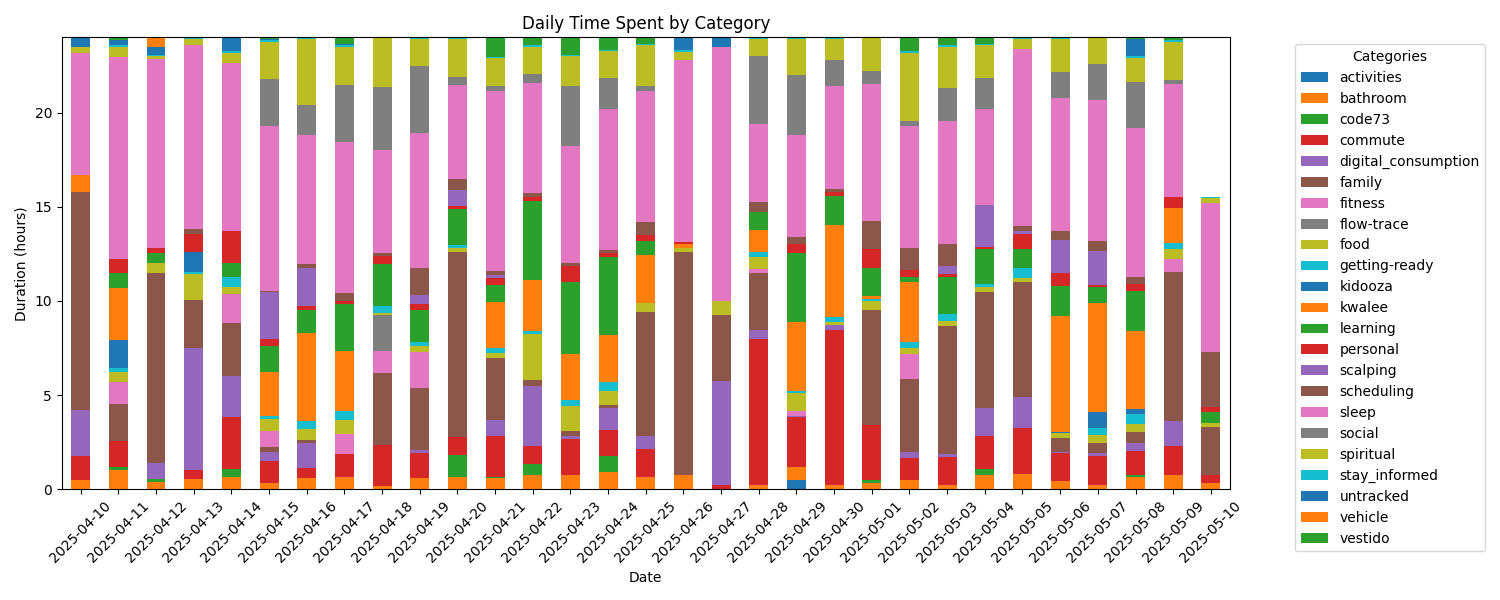

In [22]:
from calendar_ipynb.ipywidgets.bargraph_grouped_by_day import show_bargraph

show_bargraph(events)

# Last 30 Days

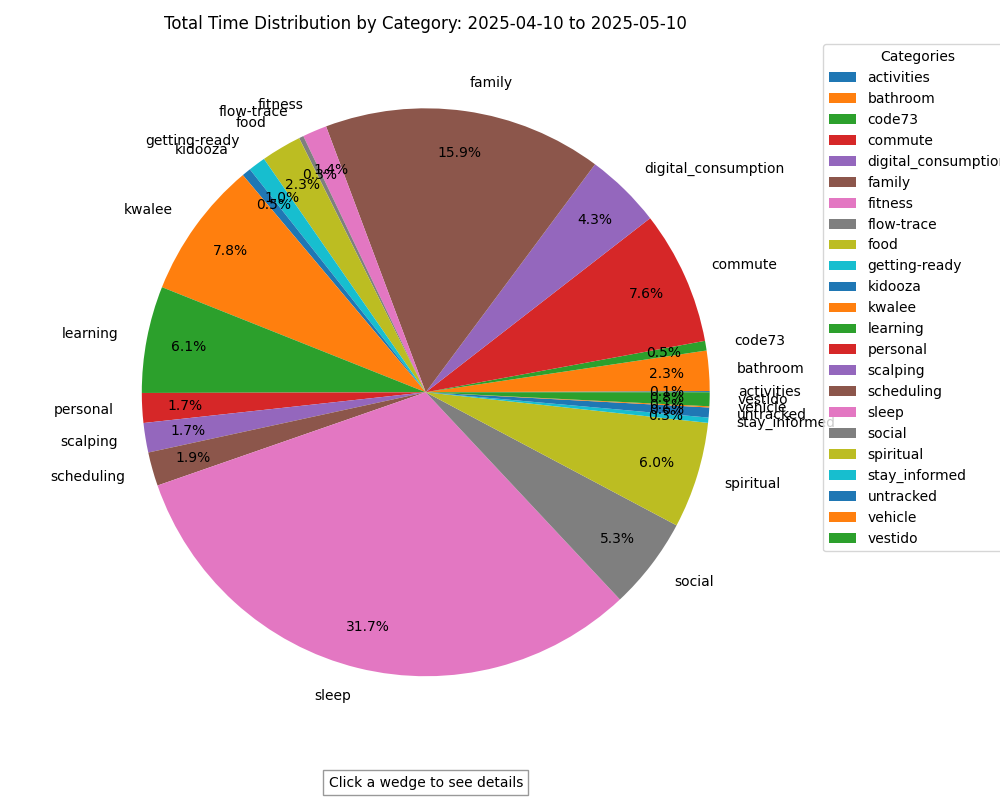

In [23]:
%matplotlib widget
from calendar_ipynb.ipywidgets.piechart import show_piechart

show_piechart(events)

# Last 7 Days Summary

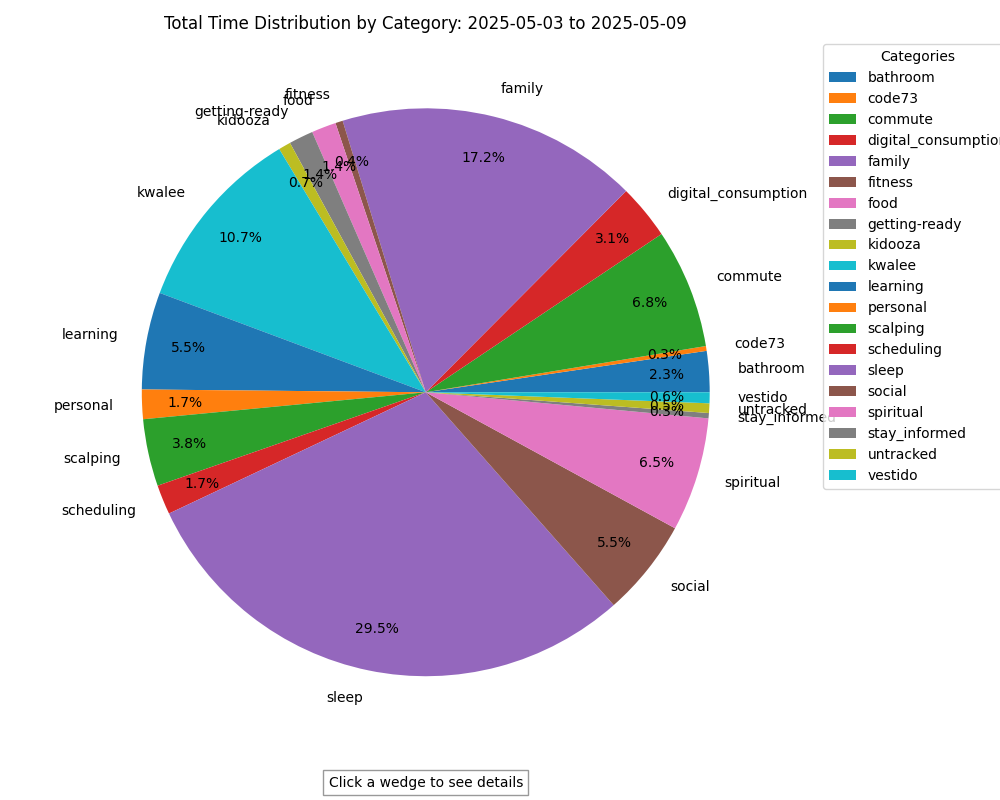

In [24]:
yesterday = datetime.date.today() - datetime.timedelta(days=1)
_7d_ago = yesterday - datetime.timedelta(days=6)
_7d_events = [
    event for event in events
    if datetime.datetime.fromisoformat(event["start"]["dateTime"]).date() >= _7d_ago
    and datetime.datetime.fromisoformat(event["start"]["dateTime"]).date() <= yesterday
]
_today_events = [event for event in events if datetime.datetime.fromisoformat(event["start"]["dateTime"]).date() == datetime.date.today()]

_events = _7d_events
# _events = _today_events
if _events:
    show_piechart(_events)
